## Imports

In [1]:
# Required for autocnet imports
import os
os.environ['ISISROOT'] = '/usgs/cpkgs/anaconda3_linux/envs/isis4.2.0'

# Autocnet Imports
from autocnet.graph.network import NetworkCandidateGraph

# Helpful Python Modules
import matplotlib.pyplot as plt  #     plotting package
import numpy as np               #     numerical computing package

## Config

In [2]:
config_path = 'config.yml'

## If your network is already in the database

In [3]:
ncg = NetworkCandidateGraph()
ncg.config_from_file(config_path)
ncg.from_database()

/work/users/jmapel/anaconda_local/envs/autocnet_local/lib/python3.7/site-packages/sqlalchemy/orm/relationships.py:1997: SAWarning: Setting backref / back_populates on relationship Overlay.points to refer to viewonly relationship Points.overlay should include sync_backref=False set on the Overlay.points relationship.  (this warning may be suppressed after 10 occurrences)
  (rel_b, rel_a, rel_b),
/work/users/jmapel/anaconda_local/envs/autocnet_local/lib/python3.7/site-packages/sqlalchemy/orm/relationships.py:1997: SAWarning: Setting backref / back_populates on relationship Points.overlay to refer to viewonly relationship Overlay.points should include sync_backref=False set on the Points.overlay relationship.  (this warning may be suppressed after 10 occurrences)
  (rel_b, rel_a, rel_b),


## If your network still needs to be ingested

In [4]:
# data_directory = "/work/projects/control_network_metrics/tutorials/isis_ingestion"
# lis_path = os.path.join(data_directory, "apollo_lronac_cubes.lis")
# cnet_path = os.path.join(data_directory, "AS15_landingsite_apollolro_jig1.net")
# ncg = NetworkCandidateGraph()
# ncg.config_from_file(config_path)
# ncg.clear_db()
# ncg = NetworkCandidateGraph.from_cnet(cnet_path, lis_path, config_path)

## Check network
We will be doing outlier detection on the edges of the graph

<AxesSubplot:>

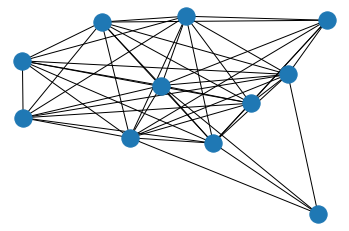

In [5]:
ncg.plot()

## SLURM parameters

In [6]:
walltime="00:30:00"
log_dir = '/scratch/jmapel/autocnet_tut/logs'
arraychunk=75
chunksize=16723 # maximum chunksize = 20,000

## Convert control measures and points to image matches
This function will collect all of the measurements of common points between each pair of images. It is very important that this function only get run once or it will add duplicate matches.

In [7]:
# njobs = ncg.apply('network_to_matches', 
#                   on='edges',
#                   # SLURM kwargs
#                   walltime=walltime,
#                   log_dir=os.path.join(log_dir, 'matches'),
#                   arraychunk=arraychunk,
#                   chunksize=chunksize)

## Looking at the matches
The pairwise image matches are stored on the edges of the graph and can be accessed via the networkX graph or the matches table in the database

In [8]:
for source, dest, edge in ncg.edges(data='data'):
    print(f'Edge ({source}, {dest}) has {len(edge.matches)} matches')

Edge (9, 4) has 3 matches
Edge (9, 8) has 42 matches
Edge (9, 5) has 3 matches
Edge (9, 11) has 239 matches
Edge (9, 7) has 213 matches
Edge (9, 3) has 3 matches
Edge (9, 2) has 3 matches
Edge (10, 4) has 4 matches
Edge (10, 8) has 477 matches
Edge (10, 5) has 4 matches
Edge (10, 6) has 440 matches
Edge (10, 11) has 39 matches
Edge (10, 7) has 54 matches
Edge (10, 3) has 4 matches
Edge (10, 2) has 4 matches
Edge (4, 8) has 4 matches
Edge (4, 5) has 199 matches
Edge (4, 6) has 4 matches
Edge (4, 11) has 5 matches
Edge (4, 1) has 82 matches
Edge (4, 7) has 2 matches
Edge (4, 3) has 271 matches
Edge (4, 2) has 166 matches
Edge (8, 5) has 4 matches
Edge (8, 6) has 419 matches
Edge (8, 11) has 171 matches
Edge (8, 7) has 184 matches
Edge (8, 3) has 4 matches
Edge (8, 2) has 4 matches
Edge (5, 6) has 4 matches
Edge (5, 11) has 5 matches
Edge (5, 1) has 19 matches
Edge (5, 7) has 2 matches
Edge (5, 3) has 181 matches
Edge (5, 2) has 89 matches
Edge (6, 11) has 38 matches
Edge (6, 7) has 46 ma

## Outlier Detection
These two functions check for outliers by attempting to reproject measures between images. Any pair of measures that do not repoject to each other wth in a given tolerance are flagged.

In [9]:
njobs = ncg.apply('compute_fundamental_matrix', 
                  on='edges',
                  # homography kwargs
                  method='lmeds',
                  reproj_threshold=5,
                  # SLURM kwargs
                  walltime=walltime,
                  log_dir=os.path.join(log_dir, 'homography'),
                  arraychunk=arraychunk,
                  chunksize=chunksize)

In [10]:
njobs = ncg.apply('compute_homography', 
                  on='edges',
                  # fundamental matrix kwargs
                  method='mle',
                  reproj_threshold=5,
                  # SLURM kwargs
                  walltime=walltime,
                  log_dir=os.path.join(log_dir, 'fundamental'),
                  arraychunk=arraychunk,
                  chunksize=chunksize)

In [11]:
ncg.queue_length

188

## Looking at the results

In [12]:
for source, dest, edge in ncg.edges(data="data"):
    num_matches = len(edge.matches)
    # MLE requires at least 8 points so skip anything with too few
    if num_matches < 8:
        continue
    print(f'edge ({source}, {dest})')
    print('num matches:', num_matches)
    print('passed homography:', sum(edge.masks['homography']))
    print('passed fundamental:', sum(edge.masks['fundamental']))
    print('too few matches to compute fundamental matrix')
    print('')

edge (9, 8)
num matches: 42
passed homography: 33
passed fundamental: 36
too few matches to compute fundamental matrix

edge (9, 11)
num matches: 239
passed homography: 162
passed fundamental: 172
too few matches to compute fundamental matrix

edge (9, 7)
num matches: 213
passed homography: 126
passed fundamental: 171
too few matches to compute fundamental matrix

edge (10, 8)
num matches: 477
passed homography: 357
passed fundamental: 452
too few matches to compute fundamental matrix

edge (10, 6)
num matches: 440
passed homography: 269
passed fundamental: 427
too few matches to compute fundamental matrix

edge (10, 11)
num matches: 39
passed homography: 34
passed fundamental: 30
too few matches to compute fundamental matrix

edge (10, 7)
num matches: 54
passed homography: 36
passed fundamental: 54
too few matches to compute fundamental matrix

edge (4, 5)
num matches: 199
passed homography: 163
passed fundamental: 171
too few matches to compute fundamental matrix

edge (4, 1)
num mat

# Digging in on edge (6, 8)

In [13]:
edge_6_8 = ncg.edges[(6, 8)]['data']
image_6 = ncg.nodes[6]
image_8 = ncg.nodes[8]
print(edge_6_8)
print(image_6)
print(image_8)


        Source Image Index: 6
        Destination Image Index: 8
        Available Masks:           fundamental  homography
match_id                         
3324             True        True
3328             True        True
3332             True        True
3336             True        True
3340             True        True
...               ...         ...
4377             True        True
4378             True        True
4379             True        True
4380             True        True
4381             True        True

[419 rows x 2 columns]
        
{'data': 
        NodeID: 6
        Image Name: /work/projects/control_network_metrics/tutorials/isis_ingestion/M102128467LE.lev1_8b.cub
        Image PATH: /work/projects/control_network_metrics/tutorials/isis_ingestion/M102128467LE.lev1_8b.cub
        Number Keypoints: 0
        Available Masks : Empty DataFrame
Columns: []
Index: []
        Type: <class 'autocnet.graph.node.NetworkNode'>
        }
{'data': 
        NodeID: 8
  

## Matches that failed the fundamental matrix check

In [14]:
failed_fundamental = edge_6_8.matches.loc[(~edge_6_8.masks[['fundamental']]).all(axis=1)]
failed_fundamental

,geom,point_id,source_measure_id,destin_measure_id,source,source_idx,destination,destination_idx,lat,lon,...,source_apriori_x,source_apriori_y,destination_x,destination_y,destination_apriori_x,destination_apriori_y,shift_x,shift_y,original_destination_x,original_destination_y
id,,,,,,,,,,,,,,,,,,,,,
3361,None,427,1387,1389,6,0,8,0,None,None,...,5036.82,32804,3577.11,33226.5,3592.08,33203.7,None,None,None,None
3765,None,600,1847,1848,6,0,8,0,None,None,...,-0.5,-0.5,907.851,30174.6,876.718,30164.8,None,None,None,None
3761,None,596,1838,1839,6,0,8,0,None,None,...,4121.38,28617.7,2321.5,29028.5,2334.64,29079.2,None,None,None,None
4193,None,867,2537,2536,6,0,8,0,None,None,...,4589.9,5724.32,2340.5,6136.5,-0.5,-0.5,None,None,None,None
4154,None,827,2429,2428,6,0,8,0,None,None,...,4671.44,634.765,2323.46,1088.92,2297,1077.35,None,None,None,None
4274,None,1012,2968,2967,6,0,8,0,None,None,...,2645.51,23126,515.094,23613.7,489.986,23603.9,None,None,None,None
4276,None,1014,2974,2973,6,0,8,0,None,None,...,4390.67,23178.6,2321.3,23598.4,2345.67,23590.4,None,None,None,None
4280,None,1026,3009,3008,6,0,8,0,None,None,...,2663.99,25122.2,531.5,25548.5,-0.5,-0.5,None,None,None,None
4305,None,1079,3149,3148,6,0,8,0,None,None,...,4662.01,32306.1,3142.41,32734.8,3169.33,32709.1,None,None,None,None


## Checking individual matches

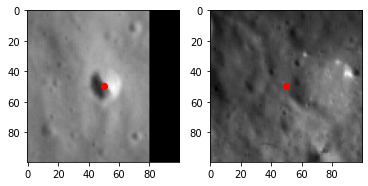

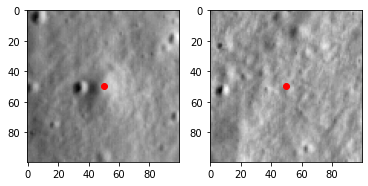

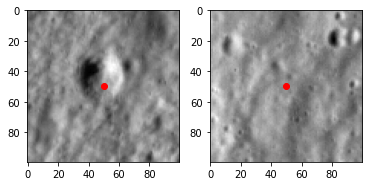

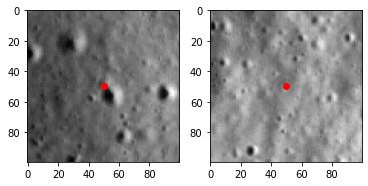

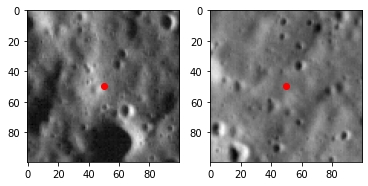

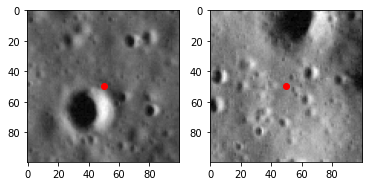

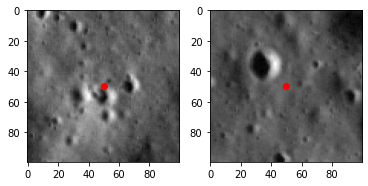

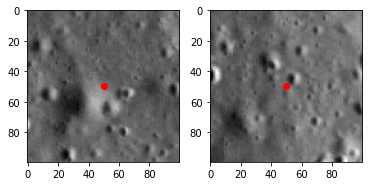

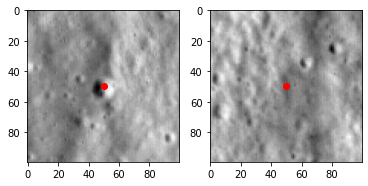

In [15]:
from autocnet.matcher.subpixel import clip_roi
size = 50
for idx, match in failed_fundamental.iterrows():
    fig, (ax1, ax2) = plt.subplots(1,2)
    source_measure, _, _ = clip_roi(image_6['data'].geodata, match['source_x'], match['source_y'], size, size)
    dest_measure, _, _ = clip_roi(image_6['data'].geodata, match['destination_x'], match['destination_y'], size, size)
    ax1.imshow(source_measure, cmap='gray')
    ax1.plot(size, size, 'ro')
    ax2.imshow(dest_measure, cmap='gray')
    ax2.plot(size, size, 'ro')
    fig.show()

## Matches that failed the homography check

In [16]:
failed_homography = edge_6_8.matches.loc[(~edge_6_8.masks[['homography']]).all(axis=1)]
failed_homography

,geom,point_id,source_measure_id,destin_measure_id,source,source_idx,destination,destination_idx,lat,lon,...,source_apriori_x,source_apriori_y,destination_x,destination_y,destination_apriori_x,destination_apriori_y,shift_x,shift_y,original_destination_x,original_destination_y
id,,,,,,,,,,,,,,,,,,,,,
3414,None,451,1457,1458,6,0,8,0,None,None,...,2806.55,4100.18,394.213,4536.13,420.01,4529.15,None,None,None,None
3387,None,438,1425,1426,6,0,8,0,None,None,...,2809.33,1005.9,287.419,1442.75,315.702,1436,None,None,None,None
3392,None,439,1428,1429,6,0,8,0,None,None,...,3695.43,1049.93,1286.5,1471.5,1261.91,1469.29,None,None,None,None
3398,None,445,1442,1443,6,0,8,0,None,None,...,2751.22,3121.24,293.225,3558.04,319.261,3551.27,None,None,None,None
3402,None,446,1445,1446,6,0,8,0,None,None,...,3253.17,3051.21,872.5,3476.5,834.419,3519.09,None,None,None,None
3420,None,456,1469,1470,6,0,8,0,None,None,...,2774.63,5118.86,372.171,5554.86,388.529,5548,None,None,None,None
4148,None,824,2423,2422,6,0,8,0,None,None,...,3437.56,673.062,987.5,1097.5,-0.5,-0.5,None,None,None,None
4156,None,834,2445,2444,6,0,8,0,None,None,...,3345.75,1645.91,987.5,2055.5,-0.5,-0.5,None,None,None,None
4162,None,842,2466,2465,6,0,8,0,None,None,...,2875,2613.53,438.5,3042.5,-0.5,-0.5,None,None,None,None


## Checking individual matches

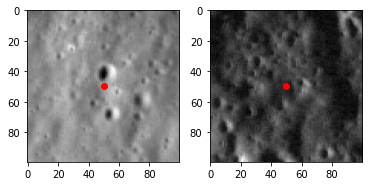

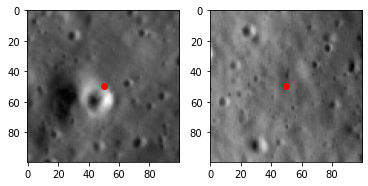

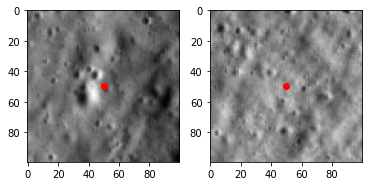

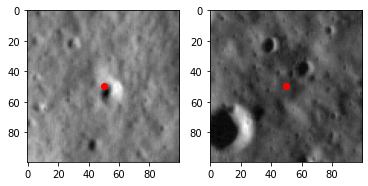

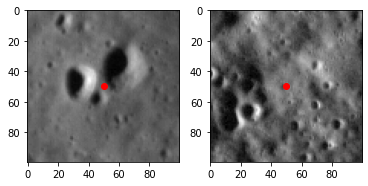

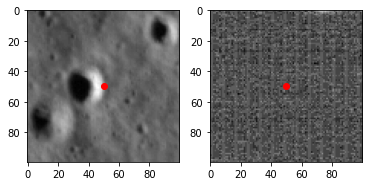

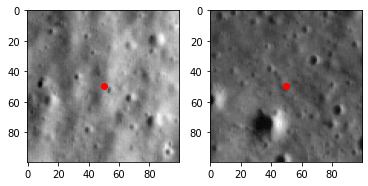

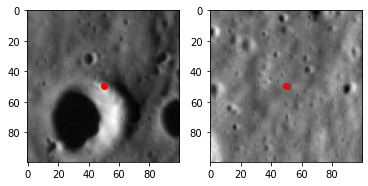

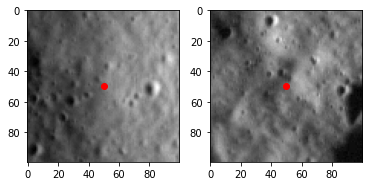

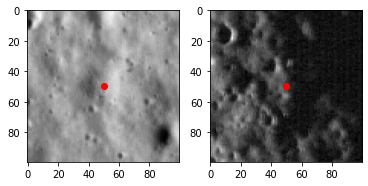

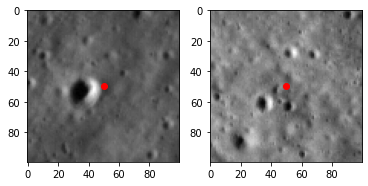

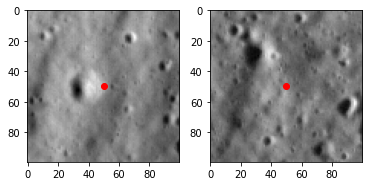

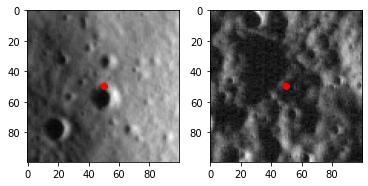

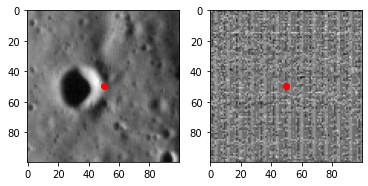

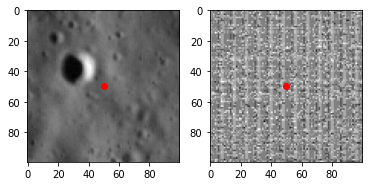

In [17]:
from autocnet.matcher.subpixel import clip_roi
size = 50
for idx, match in failed_homography.iterrows():
    fig, (ax1, ax2) = plt.subplots(1,2)
    source_measure, _, _ = clip_roi(image_6['data'].geodata, match['source_x'], match['source_y'], size, size)
    dest_measure, _, _ = clip_roi(image_6['data'].geodata, match['destination_x'], match['destination_y'], size, size)
    ax1.imshow(source_measure, cmap='gray')
    ax1.plot(size, size, 'ro')
    ax2.imshow(dest_measure, cmap='gray')
    ax2.plot(size, size, 'ro')
    fig.show()

## Matches that failed both

In [18]:
edge_6_8.matches.loc[(~edge_6_8.masks[['fundamental', 'homography']]).all(axis=1)]

,geom,point_id,source_measure_id,destin_measure_id,source,source_idx,destination,destination_idx,lat,lon,...,source_apriori_x,source_apriori_y,destination_x,destination_y,destination_apriori_x,destination_apriori_y,shift_x,shift_y,original_destination_x,original_destination_y
id,,,,,,,,,,,,,,,,,,,,,
